In [1]:
import sys
sys.path.insert(0, '..')  # adds the src folder in the path - only needed when importing from jupyter notebooks
from matplotlib import pyplot as plt

from src.data_loader import load_data_from_csv

In [2]:
df = load_data_from_csv(convert_to_pandas=True)

Loading the file using Polars...
File loaded successfully with Polars. Shape: (2302521, 308)
Converted the Polars DataFrame to Pandas.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')

# ============================================================================
# 1. GEOGRAPHIC ANALYSIS
# ============================================================================

def geographic_fire_analysis(df, lat_col='LATITUDE', lon_col='LONGITUDE', 
                             target=None, figsize=(18, 12)):
    """
    Comprehensive geographic visualization of wildfire patterns.
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    # 1. Density heatmap
    ax1 = fig.add_subplot(gs[0, :])
    
    # Create 2D histogram
    h, xedges, yedges = np.histogram2d(df[lon_col], df[lat_col], bins=50)
    
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im1 = ax1.imshow(h.T, extent=extent, origin='lower', cmap='YlOrRd', 
                     aspect='auto', interpolation='bilinear')
    ax1.set_xlabel('Longitude', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Latitude', fontsize=12, fontweight='bold')
    ax1.set_title('Wildfire Density Heatmap (Geographic Distribution)', 
                  fontsize=14, fontweight='bold', pad=15)
    
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="2%", pad=0.1)
    plt.colorbar(im1, cax=cax1, label='Fire Count')
    
    # 2. Scatter plot by target class
    ax2 = fig.add_subplot(gs[1, 0])
    
    if target and target in df.columns:
        unique_classes = df[target].unique()
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))
        
        for idx, cls in enumerate(unique_classes):
            mask = df[target] == cls
            ax2.scatter(df.loc[mask, lon_col], df.loc[mask, lat_col], 
                       alpha=0.4, s=20, c=[colors[idx]], label=f'Class {cls}',
                       edgecolors='none')
    else:
        ax2.scatter(df[lon_col], df[lat_col], alpha=0.3, s=20, c='steelblue')
    
    ax2.set_xlabel('Longitude', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Latitude', fontsize=11, fontweight='bold')
    ax2.set_title('Fire Locations by Target Class', fontsize=12, fontweight='bold')
    if target:
        ax2.legend(fontsize=8, markerscale=2)
    ax2.grid(True, alpha=0.3)
    
    # 3. Regional statistics
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Create latitude bins (regions)
    df['lat_bin'] = pd.cut(df[lat_col], bins=10, labels=False)
    regional_stats = df.groupby('lat_bin').size()
    
    ax3.bar(range(len(regional_stats)), regional_stats.values, 
            color='coral', edgecolor='black', alpha=0.7)
    ax3.set_xlabel('Latitude Region (South to North)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Fire Count', fontsize=11, fontweight='bold')
    ax3.set_title('Fire Distribution by Latitude Region', fontsize=12, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    plt.show()
    
    # Geographic statistics
    print(f"\n{'='*70}")
    print("GEOGRAPHIC STATISTICS")
    print(f"{'='*70}")
    print(f"Latitude Range: {df[lat_col].min():.2f}° to {df[lat_col].max():.2f}°")
    print(f"Longitude Range: {df[lon_col].min():.2f}° to {df[lon_col].max():.2f}°")
    print(f"Geographic Centroid: ({df[lat_col].mean():.2f}°, {df[lon_col].mean():.2f}°)")
    
    return df


# ============================================================================
# 2. FEATURE INTERACTION ANALYSIS
# ============================================================================

def feature_interaction_plots(df, feature_pairs, target, figsize=(16, 5)):
    """
    Visualize interactions between feature pairs and their relationship with target.
    """
    n_pairs = len(feature_pairs)
    fig, axes = plt.subplots(1, n_pairs, figsize=(figsize[0], figsize[1]))
    
    if n_pairs == 1:
        axes = [axes]
    
    for idx, (feat1, feat2) in enumerate(feature_pairs):
        ax = axes[idx]
        
        # Create scatter plot colored by target
        df_clean = df[[feat1, feat2, target]].dropna()
        
        for cls in df_clean[target].unique():
            mask = df_clean[target] == cls
            ax.scatter(df_clean.loc[mask, feat1], df_clean.loc[mask, feat2],
                      alpha=0.5, s=30, label=f'{target}={cls}', edgecolors='black', linewidth=0.5)
        
        ax.set_xlabel(feat1, fontsize=10, fontweight='bold')
        ax.set_ylabel(feat2, fontsize=10, fontweight='bold')
        ax.set_title(f'{feat1} vs {feat2}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8, markerscale=1.5)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def interaction_strength_matrix(df, features, n_bins=5):
    """
    Calculate and visualize feature interaction strength using mutual information.
    """
    from sklearn.feature_selection import mutual_info_classif
    from sklearn.preprocessing import KBinsDiscretizer
    
    n_features = len(features)
    interaction_matrix = np.zeros((n_features, n_features))
    
    # Discretize features for MI calculation
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    
    for i, feat1 in enumerate(features):
        for j, feat2 in enumerate(features):
            if i != j:
                # Create interaction term
                X_temp = df[[feat1, feat2]].fillna(df[[feat1, feat2]].mean())
                
                # Simple interaction: product
                interaction = (X_temp[feat1] * X_temp[feat2]).values.reshape(-1, 1)
                
                # Calculate mutual information with target
                # For this we need a target - skip if not available
                interaction_matrix[i, j] = np.corrcoef(X_temp[feat1], X_temp[feat2])[0, 1] ** 2
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(interaction_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    
    ax.set_xticks(range(n_features))
    ax.set_yticks(range(n_features))
    ax.set_xticklabels(features, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(features, fontsize=9)
    
    plt.colorbar(im, ax=ax, label='Interaction Strength (R²)')
    ax.set_title('Feature Interaction Strength Matrix', fontsize=14, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()
    
    return interaction_matrix


# ============================================================================
# 3. SEASONALITY AND CYCLICAL PATTERNS
# ============================================================================

def seasonal_analysis(df, doy_col='DISCOVERY_DOY', target=None):
    """
    Analyze seasonal patterns in wildfire occurrence.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Fire count by day of year
    doy_counts = df[doy_col].value_counts().sort_index()
    
    axes[0, 0].plot(doy_counts.index, doy_counts.values, linewidth=2, color='darkred')
    axes[0, 0].fill_between(doy_counts.index, doy_counts.values, alpha=0.3, color='red')
    axes[0, 0].set_xlabel('Day of Year', fontsize=11, fontweight='bold')
    axes[0, 0].set_ylabel('Fire Count', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Wildfire Occurrence by Day of Year', fontsize=13, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add season markers
    seasons = [(80, 172, 'Spring'), (172, 266, 'Summer'), (266, 355, 'Fall'), (355, 80, 'Winter')]
    for start, end, season in seasons[:3]:  # Skip winter for simplicity
        axes[0, 0].axvspan(start, end, alpha=0.1, color='gray')
        axes[0, 0].text((start + end) / 2, axes[0, 0].get_ylim()[1] * 0.9, 
                       season, ha='center', fontsize=9, fontweight='bold')
    
    # 2. Moving average
    window = 14  # 2-week moving average
    doy_ma = doy_counts.rolling(window=window, center=True).mean()
    
    axes[0, 1].plot(doy_counts.index, doy_counts.values, alpha=0.3, 
                   linewidth=1, color='gray', label='Daily')
    axes[0, 1].plot(doy_ma.index, doy_ma.values, linewidth=3, 
                   color='darkred', label=f'{window}-day MA')
    axes[0, 1].set_xlabel('Day of Year', fontsize=11, fontweight='bold')
    axes[0, 1].set_ylabel('Fire Count', fontsize=11, fontweight='bold')
    axes[0, 1].set_title(f'Smoothed Seasonal Pattern ({window}-day Moving Average)', 
                        fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Create seasonal bins
    df['season'] = pd.cut(df[doy_col], 
                         bins=[0, 80, 172, 266, 366],
                         labels=['Winter', 'Spring', 'Summer', 'Fall'])
    
    season_counts = df['season'].value_counts().sort_index()
    colors_seasonal = ['steelblue', 'lightgreen', 'coral', 'orange']
    
    axes[1, 0].bar(range(len(season_counts)), season_counts.values, 
                  color=colors_seasonal, edgecolor='black', alpha=0.8)
    axes[1, 0].set_xticks(range(len(season_counts)))
    axes[1, 0].set_xticklabels(season_counts.index, fontsize=10)
    axes[1, 0].set_ylabel('Fire Count', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Fire Distribution by Season', fontsize=13, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Target distribution by season (if available)
    if target and target in df.columns:
        season_target = pd.crosstab(df['season'], df[target], normalize='index') * 100
        season_target.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                          colormap='viridis', edgecolor='black', linewidth=0.5)
        axes[1, 1].set_xlabel('Season', fontsize=11, fontweight='bold')
        axes[1, 1].set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
        axes[1, 1].set_title('Target Class Distribution by Season', fontsize=13, fontweight='bold')
        axes[1, 1].legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1, 1].tick_params(axis='x', rotation=45)
    else:
        # Create monthly bins instead
        df['month'] = ((df[doy_col] - 1) // 30).clip(0, 11)
        month_counts = df['month'].value_counts().sort_index()
        axes[1, 1].bar(month_counts.index, month_counts.values, color='teal', 
                      edgecolor='black', alpha=0.7)
        axes[1, 1].set_xlabel('Month', fontsize=11, fontweight='bold')
        axes[1, 1].set_ylabel('Fire Count', fontsize=11, fontweight='bold')
        axes[1, 1].set_title('Fire Distribution by Month', fontsize=13, fontweight='bold')
        axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print(f"\n{'='*70}")
    print("SEASONAL STATISTICS")
    print(f"{'='*70}")
    print(f"\nFires by Season:")
    print(season_counts)
    print(f"\nPeak fire day: Day {doy_counts.idxmax()} with {doy_counts.max()} fires")
    print(f"Lowest fire day: Day {doy_counts.idxmin()} with {doy_counts.min()} fires")


# ============================================================================
# 4. MULTIVARIATE PARALLEL COORDINATES
# ============================================================================

def parallel_coordinates_plot(df, features, target, sample_size=500):
    """
    Parallel coordinates plot for visualizing multivariate patterns.
    """
    from pandas.plotting import parallel_coordinates
    
    # Sample data if too large
    if len(df) > sample_size:
        df_plot = df.sample(n=sample_size, random_state=42)
    else:
        df_plot = df.copy()
    
    # Select features and target
    plot_cols = features + [target]
    df_plot = df_plot[plot_cols].dropna()
    
    # Normalize features to [0, 1] for better visualization
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    df_plot_scaled = df_plot.copy()
    df_plot_scaled[features] = scaler.fit_transform(df_plot[features])
    
    # Plot
    fig, ax = plt.subplots(figsize=(16, 8))
    parallel_coordinates(df_plot_scaled, target, ax=ax, alpha=0.3, linewidth=1.5)
    
    ax.set_title('Parallel Coordinates Plot - Feature Patterns by Target Class', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel('Normalized Value', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.legend(loc='upper right', fontsize=10, title=target)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# ============================================================================
# 5. OUTLIER DETECTION VISUALIZATION
# ============================================================================

def outlier_analysis(df, features, n_std=3, figsize=(16, 10)):
    """
    Comprehensive outlier detection and visualization.
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Calculate z-scores
    from scipy.stats import zscore
    
    z_scores = np.abs(zscore(df[features].fillna(df[features].mean()), axis=0))
    outlier_mask = (z_scores > n_std).any(axis=1)
    
    # 1. Outlier count by feature
    outlier_counts = (z_scores > n_std).sum(axis=0)
    
    axes[0, 0].barh(range(len(features)), outlier_counts, color='crimson', edgecolor='black')
    axes[0, 0].set_yticks(range(len(features)))
    axes[0, 0].set_yticklabels(features, fontsize=8)
    axes[0, 0].set_xlabel('Number of Outliers', fontsize=11, fontweight='bold')
    axes[0, 0].set_title(f'Outlier Count by Feature (|Z| > {n_std})', 
                        fontsize=12, fontweight='bold')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # 2. Outlier percentage
    outlier_pct = (z_scores > n_std).sum(axis=0) / len(df) * 100
    
    axes[0, 1].barh(range(len(features)), outlier_pct, color='orange', edgecolor='black')
    axes[0, 1].set_yticks(range(len(features)))
    axes[0, 1].set_yticklabels(features, fontsize=8)
    axes[0, 1].set_xlabel('Outlier Percentage (%)', fontsize=11, fontweight='bold')
    axes[0, 1].set_title('Outlier Percentage by Feature', fontsize=12, fontweight='bold')
    axes[0, 1].axvline(x=5, color='red', linestyle='--', linewidth=2, label='5% threshold')
    axes[0, 1].invert_yaxis()
    axes[0, 1].legend()
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # 3. Max z-score distribution
    max_z_scores = z_scores.max(axis=1)
    
    axes[1, 0].hist(max_z_scores, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(x=n_std, color='red', linestyle='--', linewidth=2, 
                      label=f'Z={n_std} threshold')
    axes[1, 0].set_xlabel('Maximum |Z-Score|', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Distribution of Maximum Z-Scores per Sample', 
                        fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Scatter plot of first two features highlighting outliers
    if len(features) >= 2:
        axes[1, 1].scatter(df.loc[~outlier_mask, features[0]], 
                          df.loc[~outlier_mask, features[1]],
                          alpha=0.5, s=30, c='blue', label='Normal', edgecolors='none')
        axes[1, 1].scatter(df.loc[outlier_mask, features[0]], 
                          df.loc[outlier_mask, features[1]],
                          alpha=0.7, s=50, c='red', label='Outlier', 
                          edgecolors='black', linewidth=0.5)
        axes[1, 1].set_xlabel(features[0], fontsize=11, fontweight='bold')
        axes[1, 1].set_ylabel(features[1], fontsize=11, fontweight='bold')
        axes[1, 1].set_title('Outlier Visualization (First Two Features)', 
                            fontsize=12, fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*70}")
    print("OUTLIER ANALYSIS SUMMARY")
    print(f"{'='*70}")
    print(f"Total samples: {len(df)}")
    print(f"Samples with outliers (|Z| > {n_std}): {outlier_mask.sum()} ({outlier_mask.sum()/len(df)*100:.2f}%)")
    print(f"\nTop 5 features by outlier count:")
    print(outlier_counts.sort_values(ascending=False).head())
    
    return outlier_mask


# ============================================================================
# 6. AUTOMATED EDA REPORT GENERATOR
# ============================================================================

def generate_eda_report(df, target, output_file='eda_summary.txt'):
    """
    Generate comprehensive text-based EDA report.
    """
    with open(output_file, 'w') as f:
        f.write("="*80 + "\n")
        f.write("EXPLORATORY DATA ANALYSIS REPORT\n")
        f.write("="*80 + "\n\n")
        
        # Dataset overview
        f.write("1. DATASET OVERVIEW\n")
        f.write("-" * 80 + "\n")
        f.write(f"Total samples: {len(df)}\n")
        f.write(f"Total features: {len(df.columns)}\n")
        f.write(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n\n")
        
        # Target distribution
        if target in df.columns:
            f.write("2. TARGET VARIABLE DISTRIBUTION\n")
            f.write("-" * 80 + "\n")
            target_dist = df[target].value_counts().sort_index()
            for cls, count in target_dist.items():
                f.write(f"  Class {cls}: {count} ({count/len(df)*100:.2f}%)\n")
            f.write("\n")
        
        # Missing values
        f.write("3. MISSING VALUES ANALYSIS\n")
        f.write("-" * 80 + "\n")
        missing = df.isnull().sum()
        missing_pct = (missing / len(df) * 100).round(2)
        missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
        missing_df = missing_df[missing_df['Count'] > 0].sort_values('Count', ascending=False)
        
        if len(missing_df) > 0:
            f.write(f"Features with missing values: {len(missing_df)}\n")
            f.write(missing_df.head(10).to_string())
        else:
            f.write("No missing values detected.\n")
        f.write("\n\n")
        
        # Numeric features summary
        f.write("4. NUMERIC FEATURES SUMMARY\n")
        f.write("-" * 80 + "\n")
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        f.write(df[numeric_cols].describe().to_string())
        f.write("\n\n")
        
        # Skewness analysis
        f.write("5. SKEWNESS ANALYSIS\n")
        f.write("-" * 80 + "\n")
        skewness = df[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
        f.write("Top 10 most skewed features:\n")
        f.write(skewness.head(10).to_string())
        f.write("\n\n")
        
        f.write("="*80 + "\n")
        f.write("END OF REPORT\n")
        f.write("="*80 + "\n")
    
    print(f"✓ EDA report saved to {output_file}")


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

"""
# 1. Geographic Analysis
df = geographic_fire_analysis(train_df, target='FIRE_SIZE_CLASS')

# 2. Feature Interactions
feature_pairs = [
    ('tmmx_5D_mean', 'rmin_5D_mean'),  # Temperature vs Humidity
    ('vpd_5D_mean', 'erc_5D_mean'),     # VPD vs Energy Release
    ('NDVI-1day', 'fm100_5D_mean')      # Vegetation vs Fuel Moisture
]
feature_interaction_plots(train_df, feature_pairs, 'FIRE_SIZE_CLASS')

# 3. Interaction strength matrix
weather_features = ['pr_5D_mean', 'tmmx_5D_mean', 'vpd_5D_mean', 'erc_5D_mean']
interaction_matrix = interaction_strength_matrix(train_df, weather_features)

# 4. Seasonal Analysis
seasonal_analysis(train_df, target='FIRE_SIZE_CLASS')

# 5. Parallel Coordinates
key_features = ['tmmx_5D_mean', 'vpd_5D_mean', 'erc_5D_mean', 'NDVI-1day', 'fm100_5D_mean']
parallel_coordinates_plot(train_df, key_features, 'FIRE_SIZE_CLASS')

# 6. Outlier Analysis
outlier_mask = outlier_analysis(train_df, weather_features, n_std=3)

# 7. Generate Report
generate_eda_report(train_df, 'FIRE_SIZE_CLASS')
"""

"\n# 1. Geographic Analysis\ndf = geographic_fire_analysis(train_df, target='FIRE_SIZE_CLASS')\n\n# 2. Feature Interactions\nfeature_pairs = [\n    ('tmmx_5D_mean', 'rmin_5D_mean'),  # Temperature vs Humidity\n    ('vpd_5D_mean', 'erc_5D_mean'),     # VPD vs Energy Release\n    ('NDVI-1day', 'fm100_5D_mean')      # Vegetation vs Fuel Moisture\n]\nfeature_interaction_plots(train_df, feature_pairs, 'FIRE_SIZE_CLASS')\n\n# 3. Interaction strength matrix\nweather_features = ['pr_5D_mean', 'tmmx_5D_mean', 'vpd_5D_mean', 'erc_5D_mean']\ninteraction_matrix = interaction_strength_matrix(train_df, weather_features)\n\n# 4. Seasonal Analysis\nseasonal_analysis(train_df, target='FIRE_SIZE_CLASS')\n\n# 5. Parallel Coordinates\nkey_features = ['tmmx_5D_mean', 'vpd_5D_mean', 'erc_5D_mean', 'NDVI-1day', 'fm100_5D_mean']\nparallel_coordinates_plot(train_df, key_features, 'FIRE_SIZE_CLASS')\n\n# 6. Outlier Analysis\noutlier_mask = outlier_analysis(train_df, weather_features, n_std=3)\n\n# 7. Generate R

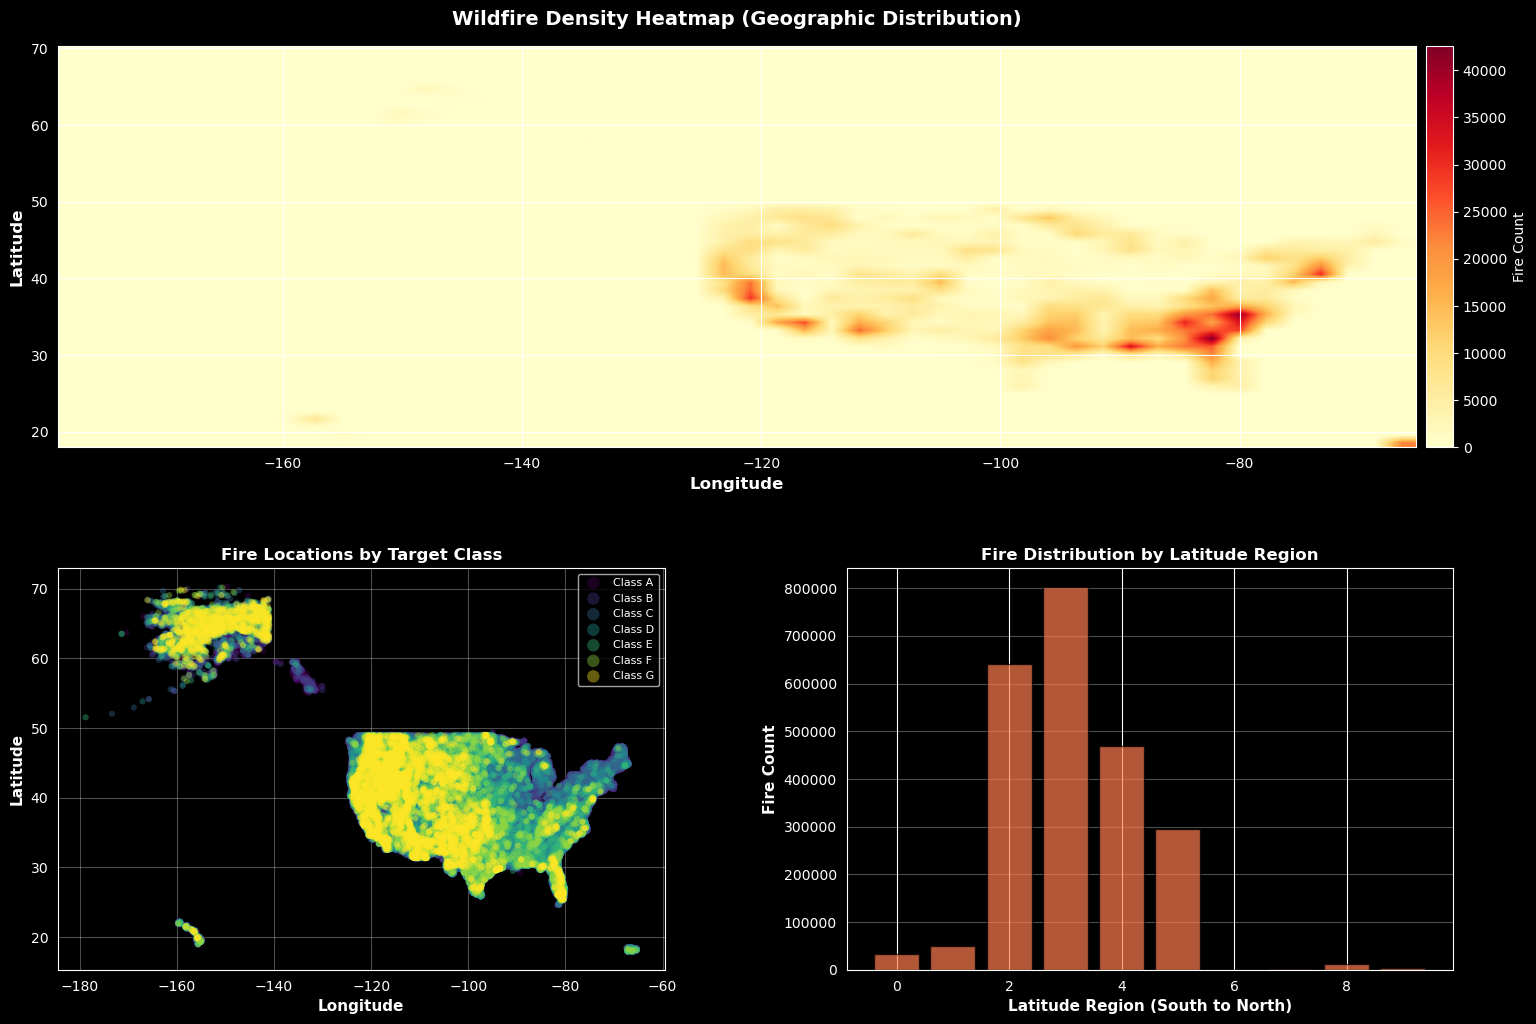


GEOGRAPHIC STATISTICS
Latitude Range: 17.94° to 70.33°
Longitude Range: -178.80° to -65.26°
Geographic Centroid: (36.97°, -96.36°)


In [7]:
df = geographic_fire_analysis(df, target='FIRE_SIZE_CLASS')

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore')

def plot_geographic_maps(df, lat_col='LATITUDE', lon_col='LONGITUDE', 
                         target=None, figsize=(18, 8)):
    """
    Create side-by-side geographic maps showing fire density and distribution by target class.
    
    Parameters:
    -----------
    df : DataFrame
        Training data
    lat_col : str
        Latitude column name
    lon_col : str
        Longitude column name
    target : str
        Target variable for classification
    figsize : tuple
        Figure size (width, height)
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1, 2, figure=fig, hspace=0.2, wspace=0.3)
    
    # ========================================================================
    # 1. HEXBIN DENSITY MAP (Left side)
    # ========================================================================
    ax1 = fig.add_subplot(gs[0, 0])
    
    hexbin = ax1.hexbin(df[lon_col], df[lat_col], gridsize=60, 
                        cmap='YlOrRd', mincnt=1, alpha=0.9, edgecolors='black', linewidths=0.2)
    ax1.set_xlabel('Longitude (°W)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Latitude (°N)', fontsize=12, fontweight='bold')
    ax1.set_title('Wildfire Density Map\n(Hexagonal binning shows fire concentration)', 
                  fontsize=14, fontweight='bold', pad=15)
    
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="3%", pad=0.1)
    cbar1 = plt.colorbar(hexbin, cax=cax1, label='Fire Count')
    cbar1.ax.tick_params(labelsize=10)
    
    # Add approximate state labels for context
    annotations = [
        (-122, 38, 'CA', 'black'),
        (-112, 40, 'UT/NV', 'black'),
        (-105, 39, 'CO', 'black'),
        (-100, 35, 'OK/TX', 'black'),
        (-84, 33, 'GA/AL', 'black'),
        (-82, 28, 'FL', 'black'),
    ]
    
    for lon, lat, label, color in annotations:
        ax1.annotate(label, xy=(lon, lat), fontsize=10, fontweight='bold',
                    color=color, ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                             alpha=0.7, edgecolor='black', linewidth=1))
    
    # ========================================================================
    # 2. FIRES BY TARGET CLASS - SCATTER MAP (Right side)
    # ========================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    
    if target and target in df.columns:
        unique_classes = sorted(df[target].unique())
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))
        
        for idx, cls in enumerate(unique_classes):
            mask = df[target] == cls
            sample_size = min(1000, mask.sum())  # Limit points for clarity
            if sample_size > 0:
                sample_idx = df[mask].sample(n=sample_size, random_state=42).index
                
                ax2.scatter(df.loc[sample_idx, lon_col], df.loc[sample_idx, lat_col], 
                           alpha=0.5, s=20, c=[colors[idx]], label=f'Class {cls}',
                           edgecolors='black', linewidth=0.3, rasterized=True)
        
        ax2.legend(fontsize=11, markerscale=2, loc='upper left', 
                  framealpha=0.95, title=target, title_fontsize=12)
    else:
        # Sample for visualization
        sample_size = min(5000, len(df))
        df_sample = df.sample(n=sample_size, random_state=42)
        ax2.scatter(df_sample[lon_col], df_sample[lat_col], 
                   alpha=0.3, s=15, c='steelblue', edgecolors='none')
    
    ax2.set_xlabel('Longitude (°W)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Latitude (°N)', fontsize=12, fontweight='bold')
    ax2.set_title('Fire Locations by Target Class\n(Sampled points colored by fire size class)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print("GEOGRAPHIC MAPS SUMMARY")
    print(f"{'='*80}")
    print(f"  • Total fires plotted: {len(df):,}")
    print(f"  • Latitude Range: {df[lat_col].min():.2f}°N to {df[lat_col].max():.2f}°N")
    print(f"  • Longitude Range: {df[lon_col].min():.2f}°W to {df[lon_col].max():.2f}°W")
    if target and target in df.columns:
        print(f"  • Target classes: {sorted(df[target].unique())}")
    print(f"{'='*80}\n")


def plot_regional_distributions(df, lat_col='LATITUDE', lon_col='LONGITUDE',
                                target=None, figsize=(18, 6)):
    """
    Create side-by-side distribution plots showing fire counts by geographic regions.
    
    Parameters:
    -----------
    df : DataFrame
        Training data
    lat_col : str
        Latitude column name
    lon_col : str
        Longitude column name
    target : str
        Target variable for classification
    figsize : tuple
        Figure size (width, height)
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1, 4, figure=fig, hspace=0.3, wspace=0.4)
    
    # Create regional bins
    lat_bins = [18, 30, 37, 42, 49, 72]
    lat_labels = ['South\n(18-30°)', 'Southeast\n(30-37°)', 'Central\n(37-42°)', 
                  'North-Central\n(42-49°)', 'North\n(49-72°)']
    
    lon_bins = [-180, -125, -110, -100, -90, -75, -65]
    lon_labels = ['Pacific\nCoast', 'Mountain\nWest', 'Great\nPlains', 
                  'Midwest', 'Southeast', 'Atlantic']
    
    df['lat_region'] = pd.cut(df[lat_col], bins=lat_bins, labels=lat_labels)
    df['lon_region'] = pd.cut(df[lon_col], bins=lon_bins, labels=lon_labels)
    
    # ========================================================================
    # 1. LATITUDE REGION DISTRIBUTION (Left)
    # ========================================================================
    ax1 = fig.add_subplot(gs[0, 0])
    
    regional_stats = df['lat_region'].value_counts().sort_index()
    
    colors_regional = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4', '#9467bd']
    bars = ax1.bar(range(len(regional_stats)), regional_stats.values, 
                   color=colors_regional, edgecolor='black', alpha=0.8, linewidth=1.5)
    
    ax1.set_xticks(range(len(regional_stats)))
    ax1.set_xticklabels(regional_stats.index, fontsize=10, rotation=45, ha='center')
    ax1.set_ylabel('Fire Count', fontsize=12, fontweight='bold')
    ax1.set_title('Fire Distribution by\nLatitude Region', 
                  fontsize=13, fontweight='bold', pad=15)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # ========================================================================
    # 2. LONGITUDE REGION DISTRIBUTION (Middle, spans 2 columns)
    # ========================================================================
    ax2 = fig.add_subplot(gs[0, 1:3])
    
    lon_stats = df['lon_region'].value_counts().sort_index()
    
    colors_lon = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    bars_lon = ax2.bar(range(len(lon_stats)), lon_stats.values, 
                       color=colors_lon, edgecolor='black', alpha=0.8, linewidth=1.5)
    
    ax2.set_xticks(range(len(lon_stats)))
    ax2.set_xticklabels(lon_stats.index, fontsize=10, rotation=45, ha='right')
    ax2.set_ylabel('Fire Count', fontsize=12, fontweight='bold')
    ax2.set_title('Fire Distribution by Longitude Region\n(East-West pattern)', 
                  fontsize=13, fontweight='bold', pad=15)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars_lon:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax3 = fig.add_subplot(gs[0, 3])
    
    if target and target in df.columns:
        # Stacked bar chart: region vs target class
        region_target = pd.crosstab(df['lat_region'], df[target], normalize='index') * 100
        region_target.plot(kind='bar', stacked=True, ax=ax3, 
                          colormap='viridis', edgecolor='black', linewidth=0.8, legend=False)
        
        ax3.set_xlabel('Region', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
        ax3.set_title('Target Class\nDistribution\nby Region', 
                      fontsize=12, fontweight='bold', pad=15)
        ax3.tick_params(axis='x', rotation=45, labelsize=9)
        ax3.grid(axis='y', alpha=0.3)
        ax3.set_ylim(0, 100)
        
        # Add legend
        handles, labels = ax3.get_legend_handles_labels()
        ax3.legend(handles, labels, title=target, loc='upper right', 
                  fontsize=9, title_fontsize=10, framealpha=0.9)
    else:
        # Show message if no target
        ax3.text(0.5, 0.5, 'No target\nvariable\nprovided', 
                ha='center', va='center', fontsize=12, 
                transform=ax3.transAxes, fontweight='bold')
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.set_title('Target Distribution\nby Region', fontsize=12, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # STATISTICAL SUMMARY
    # ========================================================================
    print(f"\n{'='*80}")
    print("REGIONAL DISTRIBUTION SUMMARY")
    print(f"{'='*80}")
    
    print(f"\n🔥 TOP 3 LATITUDE REGIONS BY FIRE COUNT:")
    for i, (region, count) in enumerate(regional_stats.head(3).items(), 1):
        print(f"  {i}. {region}: {int(count):,} fires ({count/len(df)*100:.1f}%)")
    
    print(f"\n🌎 TOP 3 LONGITUDE REGIONS BY FIRE COUNT:")
    for i, (region, count) in enumerate(lon_stats.head(3).items(), 1):
        print(f"  {i}. {region}: {int(count):,} fires ({count/len(df)*100:.1f}%)")
    
    if target and target in df.columns:
        print(f"\n🎯 REGIONAL TARGET CLASS PATTERNS:")
        print(f"  (Looking for regions with higher proportions of severe fires)")
        
        for region in region_target.index:
            max_class = region_target.loc[region].idxmax()
            max_pct = region_target.loc[region, max_class]
            print(f"  • {region}: Class {max_class} dominates ({max_pct:.1f}%)")
    
    print(f"\n{'='*80}\n")
    
    return df


def create_geographic_insights_table(df, lat_col='LATITUDE', lon_col='LONGITUDE', 
                                     target=None):
    """
    Create a summary table of geographic patterns.
    """
    # Define regions
    lat_bins = [18, 30, 37, 42, 49, 72]
    lat_labels = ['South (18-30°)', 'Southeast (30-37°)', 'Central (37-42°)', 
                  'North-Central (42-49°)', 'North (49-72°)']
    
    df['lat_region'] = pd.cut(df[lat_col], bins=lat_bins, labels=lat_labels)
    
    # Calculate statistics by region
    summary_stats = []
    
    for region in lat_labels:
        region_data = df[df['lat_region'] == region]
        
        stats = {
            'Region': region,
            'Fire Count': len(region_data),
            'Percentage': len(region_data) / len(df) * 100,
            'Avg Latitude': region_data[lat_col].mean(),
            'Avg Longitude': region_data[lon_col].mean(),
        }
        
        if target and target in df.columns:
            # Most common target class
            mode_class = region_data[target].mode()[0] if len(region_data) > 0 else None
            stats['Most Common Class'] = mode_class
            stats['Class %'] = (region_data[target] == mode_class).sum() / len(region_data) * 100 if len(region_data) > 0 else 0
        
        summary_stats.append(stats)
    
    summary_df = pd.DataFrame(summary_stats)
    
    # Display as formatted table
    print("\n" + "="*100)
    print("GEOGRAPHIC SUMMARY TABLE")
    print("="*100)
    print(summary_df.to_string(index=False))
    print("="*100 + "\n")
    
    return summary_df


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

"""
# Load your data
train_df = pd.read_csv('train_data.csv')

# ============================================================================
# OPTION 1: Run both functions separately
# ============================================================================

# Plot geographic maps (density and target class distribution)
plot_geographic_maps(
    train_df, 
    lat_col='LATITUDE', 
    lon_col='LONGITUDE',
    target='FIRE_SIZE_CLASS'
)

# Plot regional distribution bar charts
df_with_regions = plot_regional_distributions(
    train_df,
    lat_col='LATITUDE',
    lon_col='LONGITUDE', 
    target='FIRE_SIZE_CLASS'
)

# ============================================================================
# OPTION 2: Create summary table
# ============================================================================
summary_table = create_geographic_insights_table(
    train_df,
    target='FIRE_SIZE_CLASS'
)

# ============================================================================
# Interpretation Notes for Your Milestone:
# ============================================================================
# 
# GEOGRAPHIC MAPS (plot_geographic_maps):
#   - Hexbin map: Shows WHERE fires concentrate geographically (density hotspots)
#   - Scatter map: Shows IF different fire size classes cluster in different regions
# 
# REGIONAL DISTRIBUTIONS (plot_regional_distributions):
#   - Left: Which latitude bands have the most fires? (South to North)
#   - Middle: Which longitude regions have most fires? (Pacific Coast to Atlantic)
#   - Right: Do certain regions have higher proportions of severe fires?
#
# Key Insights to Report in Your Milestone:
# -----------------------------------------
# 1. Geographic hotspots: "Fires concentrate in [X region], with Y% of all fires"
# 2. Regional fire severity: "The Southeast region shows Z% Class G fires vs A% nationally"
# 3. East-West patterns: "Western regions (Pacific Coast + Mountain West) account for B% of fires"
# 4. Implications: "Geographic heterogeneity suggests regional features (climate zones, 
#    vegetation types, population density) should be important predictors in our models"
"""

'\n# Load your data\ntrain_df = pd.read_csv(\'train_data.csv\')\n\n# ============================================================================\n# OPTION 1: Run both functions separately\n# ============================================================================\n\n# Plot geographic maps (density and target class distribution)\nplot_geographic_maps(\n    train_df, \n    lat_col=\'LATITUDE\', \n    lon_col=\'LONGITUDE\',\n    target=\'FIRE_SIZE_CLASS\'\n)\n\n# Plot regional distribution bar charts\ndf_with_regions = plot_regional_distributions(\n    train_df,\n    lat_col=\'LATITUDE\',\n    lon_col=\'LONGITUDE\', \n    target=\'FIRE_SIZE_CLASS\'\n)\n\n# ============================================================================\n# OPTION 2: Create summary table\n# ============================================================================\nsummary_table = create_geographic_insights_table(\n    train_df,\n    target=\'FIRE_SIZE_CLASS\'\n)\n\n# ====================================

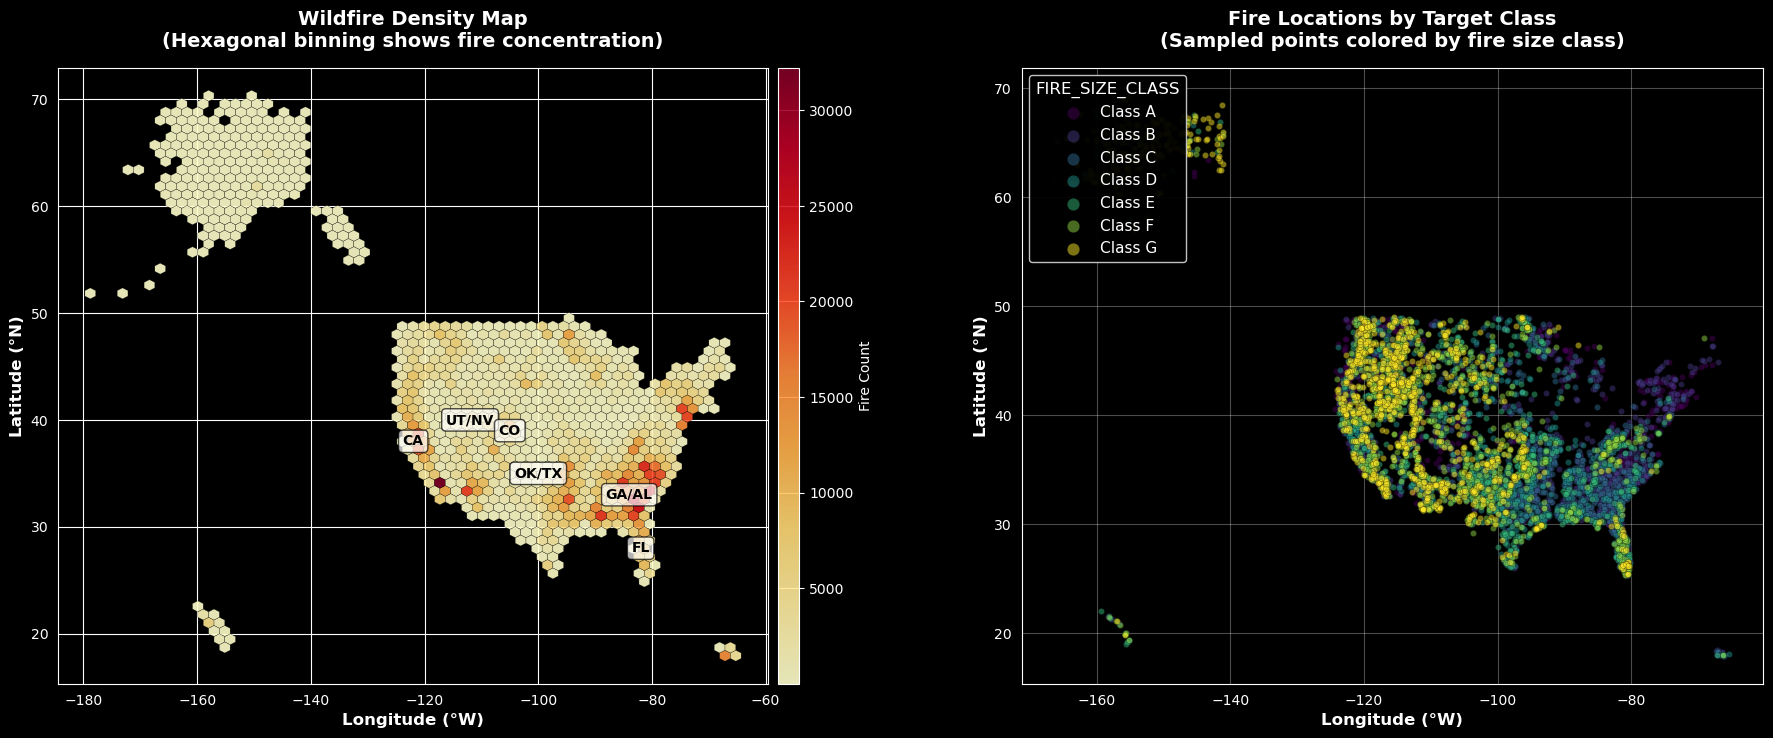


GEOGRAPHIC MAPS SUMMARY
  • Total fires plotted: 2,302,521
  • Latitude Range: 17.94°N to 70.33°N
  • Longitude Range: -178.80°W to -65.26°W
  • Target classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G']



In [23]:
plot_geographic_maps(
    df, 
    lat_col='LATITUDE', 
    lon_col='LONGITUDE',
    target='FIRE_SIZE_CLASS',
    figsize=(22, 8)
)

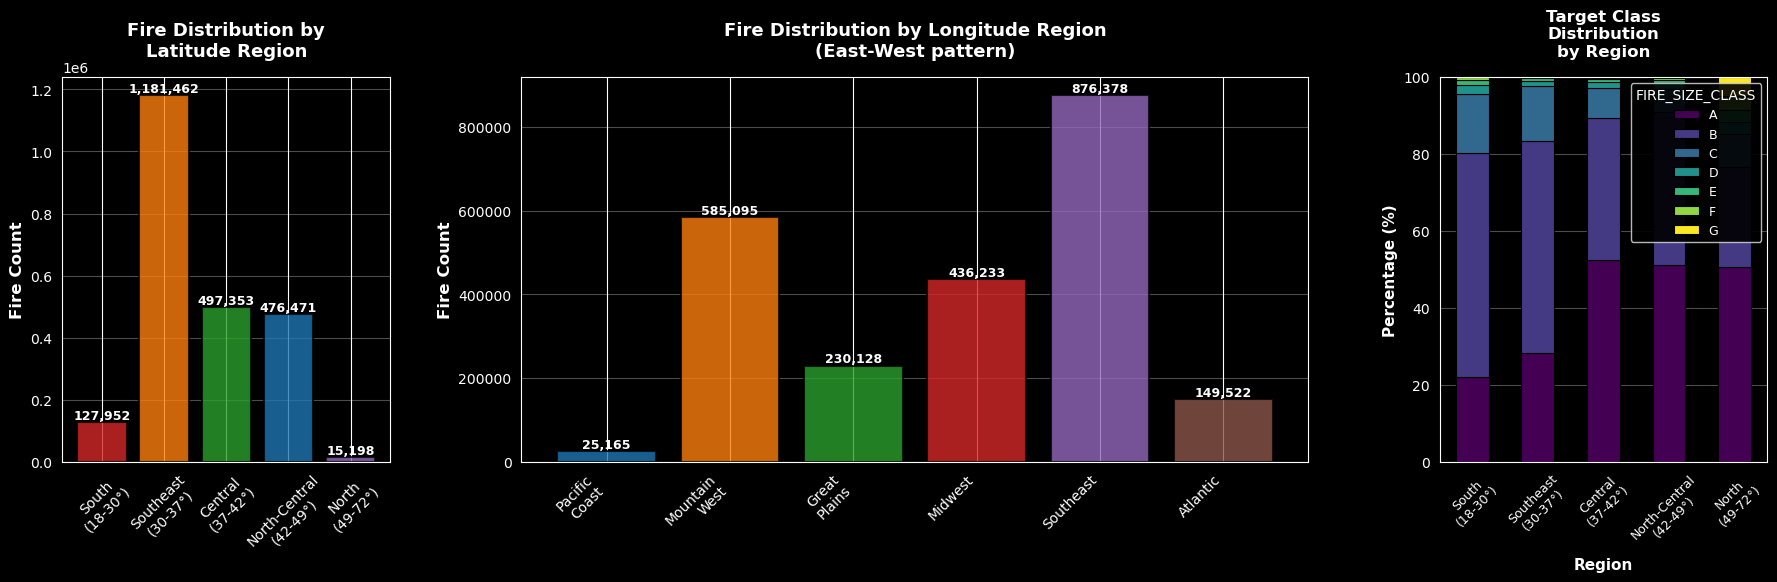


REGIONAL DISTRIBUTION SUMMARY

🔥 TOP 3 LATITUDE REGIONS BY FIRE COUNT:
  1. South
(18-30°): 127,952 fires (5.6%)
  2. Southeast
(30-37°): 1,181,462 fires (51.3%)
  3. Central
(37-42°): 497,353 fires (21.6%)

🌎 TOP 3 LONGITUDE REGIONS BY FIRE COUNT:
  1. Pacific
Coast: 25,165 fires (1.1%)
  2. Mountain
West: 585,095 fires (25.4%)
  3. Great
Plains: 230,128 fires (10.0%)

🎯 REGIONAL TARGET CLASS PATTERNS:
  (Looking for regions with higher proportions of severe fires)
  • South
(18-30°): Class B dominates (58.3%)
  • Southeast
(30-37°): Class B dominates (55.1%)
  • Central
(37-42°): Class A dominates (52.5%)
  • North-Central
(42-49°): Class A dominates (51.2%)
  • North
(49-72°): Class A dominates (50.6%)




In [26]:
df_with_regions = plot_regional_distributions(
    df,
    lat_col='LATITUDE',
    lon_col='LONGITUDE', 
    target='FIRE_SIZE_CLASS',
    figsize=(22, 5)
)